
  DEMO : MODE HALF-DUPLEX + CRC + BRUIT (OPTION)
Choisissez si vous voulez ajouter du bruit (True/False) 
et le niveau de SNR (ex. 20 dB)

=== PHASE 1 : Saisissez votre message ===

=== ÉMISSION & RÉCEPTION DU MESSAGE ===
=== ÉMISSION : CRC ===
Données + CRC : [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
=== ÉMISSION : TRAME ===
Fanion début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Protocole    : [1, 1, 0, 0, 0, 0, 1, 1]
Trame finale : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
=== ÉMISSION : Manchester ===
Manchester (extrait) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] ...
=== ÉMISSION : Modulation => fichiers Message_ASK.csv, Message_FSK.csv ===


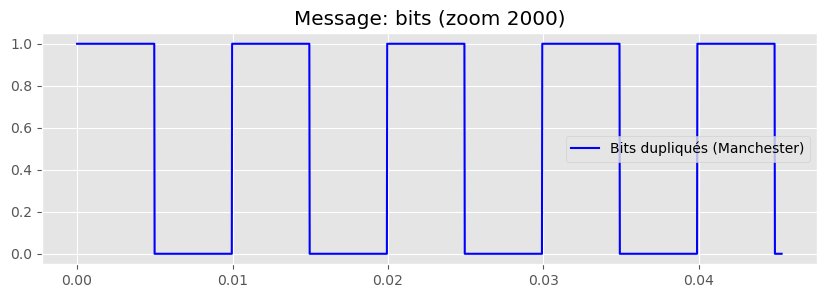

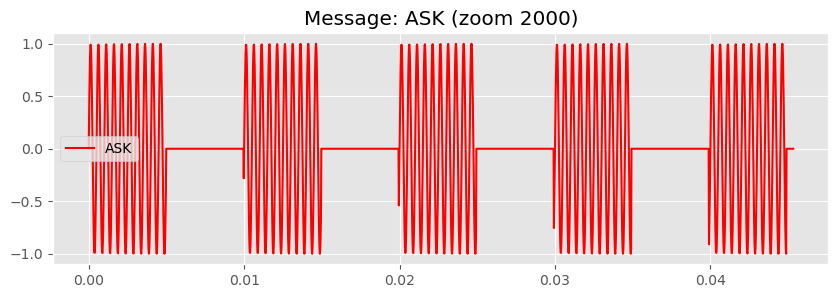

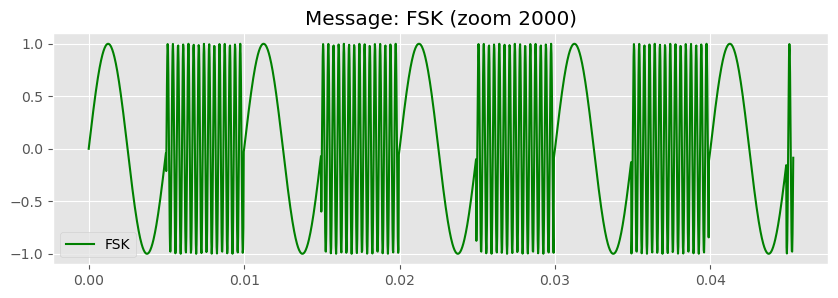


=== RÉCEPTION DE Message ===
--- RÉCEPTION : On ajoute du bruit SNR=20 dB sur Message. ---
Bits démodulés (extrait) : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Trame invalide pour Message.

Échec de réception du message, pas d'ACK.



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import time

plt.style.use('ggplot')

###############################################################################
#                          PARAMÈTRES GLOBAUX
###############################################################################
Fe    = 44100               # Fréquence d'échantillonnage
baud  = 200                 # Débit binaire en bit/s
Ns    = int(Fe / baud)      # Nombre d'échantillons par bit (~220)
Fp_ASK = 2000               # Porteuse ASK
fp1    = 200                # Porteuse FSK (bit = 1)
fp2    = 3000               # Porteuse FSK (bit = 0)

###############################################################################
#             FONCTION DE LECTURE AUDIO SÉCURISÉE (safe_play)
###############################################################################
def safe_play(signal, samplerate):
    try:
        sd.play(signal, samplerate)
        sd.wait()
        sd.stop()
        time.sleep(0.2)
    except Exception as e:
        print("Erreur lors de la lecture audio :", e)

###############################################################################
#                 FONCTION DE VALIDATION DES FANIONS
###############################################################################
def is_valid_fanion(received, expected, tolerance=4):
    mismatches = sum(1 for r, e in zip(received, expected) if r != e)
    return mismatches <= tolerance

###############################################################################
#                        FONCTIONS POUR L'ÉMISSION
###############################################################################
def crcemission(bits):
    diviseur = int("1001", 2)
    resultat_crc = []
    local_bits = bits[:]
    while len(local_bits) >= 8:
        donne_str = ''.join(map(str, local_bits[:8]))
        local_bits = local_bits[8:]
        div_str = donne_str + "0000"
        div_int = int(div_str, 2)
        _, reste = divmod(div_int, diviseur)
        resultat_crc.extend(map(int, donne_str))
        resultat_crc.extend(map(int, format(reste, '04b')))
    print("=== ÉMISSION : CRC ===")
    print("Données + CRC :", resultat_crc)
    return resultat_crc

def trame_emission(bits, type_fichier="txt"):
    """
    Ici, nous utilisons des fanions de 16 bits (au lieu de 8) pour renforcer la robustesse.
    """
    fanion_debut = [1] * 16
    fanion_fin   = [0] * 16
    prot_txt     = [1,1,0,0,0,0,1,1] if type_fichier=="txt" else [0]*8
    trame = fanion_debut + prot_txt + bits + fanion_fin
    print("=== ÉMISSION : TRAME ===")
    print("Fanion début :", fanion_debut)
    print("Fanion fin   :", fanion_fin)
    print("Protocole    :", prot_txt)
    print("Trame finale :", trame)
    return trame

def Manchester_encode(bits):
    code = []
    for b in bits:
        if b == 1:
            code.extend([1,0])
        else:
            code.extend([0,1])
    print("=== ÉMISSION : Manchester ===")
    print("Manchester (extrait) :", code[:20], "...")
    return code

def modulation_ASK_FSK(bits_manchester, filename_prefix="Message"):
    bits_dupliques = np.repeat(bits_manchester, Ns)
    N = len(bits_dupliques)
    t = np.arange(N) / Fe

    # Signal ASK
    porteuse = np.sin(2*np.pi*Fp_ASK*t)
    ASK = bits_dupliques * porteuse

    # Signal FSK
    s1 = np.sin(2*np.pi*fp1*t)
    s2 = np.sin(2*np.pi*fp2*t)
    FSK = np.where(bits_dupliques == 1, s1, s2)

    # Sauvegarde
    ask_file = f"{filename_prefix}_ASK.csv"
    fsk_file = f"{filename_prefix}_FSK.csv"
    np.savetxt(ask_file, ASK, fmt="%.6f", delimiter=',')
    np.savetxt(fsk_file, FSK, fmt="%.6f", delimiter=',')
    print(f"=== ÉMISSION : Modulation => fichiers {ask_file}, {fsk_file} ===")

    # Lecture audio (votre ancien code jouait le son ici)
    sd.play(ASK, Fe)
    sd.wait()
    sd.play(FSK, Fe)
    sd.wait()

    # Graphiques (zoom sur 2000 échantillons)
    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], bits_dupliques[:2000], color='blue', label='Bits dupliqués (Manchester)')
    plt.title(f"{filename_prefix}: bits (zoom 2000)")
    plt.legend()
    plt.grid(True)
    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], ASK[:2000], color='red', label='ASK')
    plt.title(f"{filename_prefix}: ASK (zoom 2000)")
    plt.legend()
    plt.grid(True)
    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], FSK[:2000], color='green', label='FSK')
    plt.title(f"{filename_prefix}: FSK (zoom 2000)")
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
#                     FONCTIONS POUR LA RÉCEPTION
###############################################################################
def add_noise_to_signal(signal, snr_db=20):
    snr_linear = 10 ** (snr_db / 10.0)
    signal_power = np.mean(signal ** 2)
    noise_power  = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=len(signal))
    return signal + noise

def demodulation_ASK_FSK(filename_prefix="Message", add_noise=False, snr_db=20):
    ask_file = f"{filename_prefix}_ASK.csv"
    fsk_file = f"{filename_prefix}_FSK.csv"
    ASK_signal = np.genfromtxt(ask_file, delimiter=',')
    if add_noise:
        print(f"--- RÉCEPTION : On ajoute du bruit SNR={snr_db} dB sur {filename_prefix}. ---")
        ASK_signal = add_noise_to_signal(ASK_signal, snr_db)
    else:
        print(f"--- RÉCEPTION : Pas de bruit pour {filename_prefix}. ---")
    N = len(ASK_signal)
    t = np.arange(N) / Fe
    porteuse = np.sin(2 * np.pi * Fp_ASK * t)
    produit = ASK_signal * porteuse
    bits = []
    threshold = -0.2  # Seuil ajusté à -0.2 pour compenser le bruit
    for i in range(0, N, Ns):
        portion = produit[i : i + Ns]
        val = np.trapz(portion)
        bits.append(1 if val > threshold else 0)
    print("Bits démodulés (extrait) :", bits[:40])
    return bits

def Manchester_decode(bits):
    decode = []
    for i in range(0, len(bits), 2):
        b1 = bits[i]
        b2 = bits[i+1]
        if (b1, b2) == (1, 0):
            decode.append(1)
        elif (b1, b2) == (0, 1):
            decode.append(0)
    return decode

def trame_reception(bits):
    """
    Extrait le fanion de début, le fanion de fin, l'octet protocole et les données+CRC.
    On suppose ici que le fanion de début et de fin sont sur 8 bits.
    Retourne (data_crc, type_fichier) ou (None, None) si la trame est invalide.
    """
    if len(bits) < 16:
        return None, None
    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    core = bits[8:-8]
    if fanion_debut != [1]*8 or fanion_fin != [0]*8:
        print("Fanion attendu :", [1]*8, "mais reçu :", fanion_debut)
        return None, None
    if len(core) < 8:
        return None, None
    protocole = core[:8]
    data_crc  = core[8:]
    type_fic = "txt" if protocole == [1,1,0,0,0,0,1,1] else "?"
    return data_crc, type_fic

def crcreception(bits):
    diviseur = int("1001", 2)
    idx = 0
    data_res = []
    integrite_ok = True
    while idx + 12 <= len(bits):
        bloc = bits[idx:idx+12]
        idx += 12
        data_8 = bloc[:8]
        reste_4 = bloc[8:]
        data_str = "".join(str(x) for x in data_8)
        data_plus_0000 = data_str + "0000"
        data_dec = int(data_plus_0000, 2)
        reste_calc = data_dec % diviseur
        reste_calc_str = format(reste_calc, '04b')
        recu_str = "".join(str(x) for x in reste_4)
        if reste_calc_str != recu_str:
            integrite_ok = False
        data_res.extend(data_8)
    return data_res if integrite_ok else None

def ASCII_decode(bits, type_fic):
    if type_fic != "txt" or not bits:
        return "[Protocole inconnu / bits vides]"
    chaine = ""
    for i in range(0, len(bits), 8):
        octet = bits[i:i+8]
        if len(octet) < 8:
            break
        val = int("".join(str(b) for b in octet), 2)
        chaine += chr(val)
    return chaine

###############################################################################
#             HALF-DUPLEX AVEC ACK + GESTION DU BRUIT
###############################################################################
def emission_reception(prefix, message, add_noise=False, snr_db=20):
    # Conversion ASCII -> bits
    bits_texte = []
    for c in message:
        bits_texte.extend(int(x) for x in format(ord(c), '08b'))
    
    # Calcul du CRC
    bits_crc = crcemission(bits_texte)
    # Construction de la trame
    bits_trame = trame_emission(bits_crc, "txt")
    # Codage Manchester
    bits_manch = Manchester_encode(bits_trame)
    # Modulation et enregistrement
    modulation_ASK_FSK(bits_manch, filename_prefix=prefix)
    
    print(f"\n=== RÉCEPTION DE {prefix} ===")
    # Démodulation (avec option bruit)
    ask_bits = demodulation_ASK_FSK(filename_prefix=prefix, add_noise=add_noise, snr_db=snr_db)
    # Décodage Manchester
    decode_manch = Manchester_decode(ask_bits)
    # Extraction de la trame
    data_crc, type_fic = trame_reception(decode_manch)
    if data_crc is None or type_fic is None:
        print(f"Trame invalide pour {prefix}.\n")
        return None
    # Vérification CRC
    data_sans_crc = crcreception(data_crc)
    if data_sans_crc is None:
        print(f"CRC invalide pour {prefix}.\n")
        return None
    # Décodage ASCII
    final_txt = ASCII_decode(data_sans_crc, type_fic)
    print(f"Message final reçu pour {prefix} :", final_txt, "\n")
    return final_txt

def half_duplex_demo(add_noise=False, snr_db=20):
    print("=== PHASE 1 : Saisissez votre message ===")
    texte = ""
    while not texte:
        texte = input("Votre message : ")
    
    print("\n=== ÉMISSION & RÉCEPTION DU MESSAGE ===")
    msg_recu = emission_reception("Message", texte, add_noise=add_noise, snr_db=snr_db)
    if msg_recu is None:
        print("Échec de réception du message, pas d'ACK.\n")
        return
    
    time.sleep(1)
    
    print("=== PHASE 2 : ÉMISSION & RÉCEPTION D'UN ACK ===")
    ack_str = "OK"
    ack_recu = emission_reception("ACK", ack_str, add_noise=add_noise, snr_db=snr_db)
    if ack_recu is None:
        print("ACK non reçu ou corrompu.\n")
        return
    print("=== FIN DU HALF-DUPLEX ===")

###############################################################################
#                          PROGRAMME PRINCIPAL
###############################################################################
if __name__=="__main__":
    print("""
==================================================
  DEMO : MODE HALF-DUPLEX + CRC + BRUIT (OPTION)
==================================================
Choisissez si vous voulez ajouter du bruit (True/False) 
et le niveau de SNR (ex. 20 dB)
""")
    noise_flag = True
    noise_snr  = 20  # SNR = 20 dB (bruit modéré)
    
    half_duplex_demo(add_noise=noise_flag, snr_db=noise_snr)
